In [ ]:
#|default_exp schedulers

# Schedulers
> Additional model training schedulers for fastai

In [ ]:
#|export
from __future__ import annotations

import numpy as np

from fastcore.basics import even_mults

from fastai.callback.core import Callback
from fastai.callback.schedule import SchedCos, SchedNo, combine_scheds, ParamScheduler, _Annealer
from fastai.learner import Learner

from fastxtend.basics import is_listish
from fastxtend.imports import *

In [ ]:
#|hide
from fastai.callback.schedule import SchedLin
from fastai.test_utils import synth_learner

## Fit Flat Warmup -

In [ ]:
#|export
@patch
def fit_flat_warmup(self:Learner, 
    n_epoch:int, # Number of epochs
    lr:float|None=None, # Maximum learning rate
    div:Number=25., # Initial learning rate: `lr/div`
    div_final:Number=1e5, # Final learning rate: `lr/div_final`
    pct_start:float=0.75, # Start learning rate cosine annealing
    warm_pct:float=0.2, # Learning rate warmup in percent
    warm_epoch:int=5, # Learning rate warmup in epochs
    warm_mode:str='auto', # Warmup using 'epoch', 'pct', or min of epoch/pct if 'auto'
    warm_sched:Callable[..., _Annealer]=SchedCos, # Learning rate warmup schedule
    wd:float|None=None, # Weight decay, defaults to `Optimizer` weight decay
    cbs:listified[Callback]|None=None, # Temporary Callbacks to apply during fit
    reset_opt:bool=False # Reset `Optimizer` before fit
):
    "Fit `self.model` for `n_epoch` at flat `lr` with a warmup and ending with cosine annealing."
    if self.opt is None: 
        self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr is None else lr)

    if warm_mode=='auto':
        warm_pct = min(warm_epoch/n_epoch, warm_pct)
    elif warm_mode=='epoch':
        warm_pct = warm_epoch/n_epoch

    pcts = [warm_pct, 1-(warm_pct+(1-pct_start)), 1-pct_start]
    scheds = [warm_sched(lr/div, lr), SchedNo(lr,lr), SchedCos(lr, lr/div_final)]
    scheds = {'lr': combine_scheds(pcts, scheds)}

    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=0)

`fit_flat_warmup` is identical to fastai's [`fit_flat_cos`](https://docs.fast.ai/callback.schedule.html#learner.fit_flat_cos), except with an added learning rate warmup phase.

By default, `fit_flat_warmup` will apply learning rate warmup for a minimum of `warm_pct` percent of training steps or `warm_epoch` number of training epochs. Set `warm_mode='pct'` to warmup the learning rate for `warm_pct` percent of training steps or set `warm_mode='epoch'` to warmup the learning rate for `warm_epoch` number of epochs.

`warm_sched` can be one of [`SchedCos`](https://docs.fast.ai/callback.schedule.html#schedcos) (the default), [`SchedLin`](https://docs.fast.ai/callback.schedule.html#schedlin),[`SchedExp`](https://docs.fast.ai/callback.schedule.html#schedexp), [`SchedPoly`](https://docs.fast.ai/callback.schedule.html#schedpoly), or a custom [fastai annealer](https://docs.fast.ai/callback.schedule.html#annealer) based schedule. `SchedPoly` must be passed as partial function: `partial(SchedPoly, power=0.5)`.

In [ ]:
#|hide
learn = synth_learner(100, 10)
learn.fit_flat_warmup(10, 8e-3)

epoch,train_loss,valid_loss,time
0,2.915178,0.041057,00:00
1,0.350864,0.010789,00:00
2,0.054753,0.011043,00:00
3,0.015696,0.010882,00:00
4,0.010951,0.011181,00:00
5,0.010294,0.011282,00:00
6,0.010050,0.010797,00:00
7,0.010312,0.010678,00:00
8,0.009915,0.011020,00:00
9,0.009799,0.010863,00:00


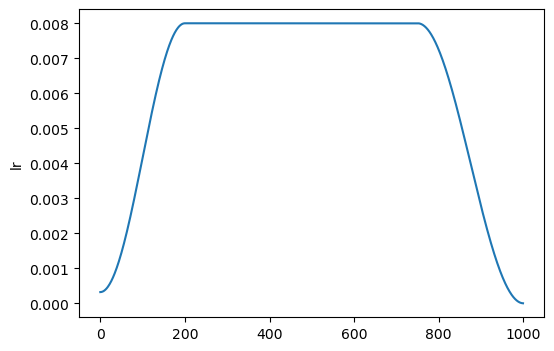

In [ ]:
#|echo: false
learn.recorder.plot_sched()

## Fit Cos Anneal -

In [ ]:
#|export
@patch
def fit_cos_anneal(self:Learner, 
    n_epoch:int, # Number of epochs
    lr:float|None=None, # Maximum learning rate
    div:Number=25., # Initial learning rate: `lr/div`
    div_final:Number=1e5, # Final learning rate: `lr/div_final`
    warm_pct:float=0.2, # Learning rate warmup in percent
    warm_epoch:int=5, # Learning rate warmup in epochs
    warm_mode:str='auto', # Warmup using 'epoch', 'pct', or min of epoch/pct 'auto'
    warm_sched:Callable[..., _Annealer]=SchedCos, # Learning rate warmup schedule
    wd:float|None=None, # Weight decay, defaults to `Optimizer` weight decay
    cbs:listified[Callback]|None=None, # Temporary Callbacks to apply during fit
    reset_opt:bool=False # Reset `Optimizer` before fit
):
    "Fit `self.model` for `n_epoch` using a with cosine annealing schedule with a max `lr` and optional warmup."
    if self.opt is None:
        self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr is None else lr)

    if warm_mode=='auto':
        warm_pct = min(warm_epoch/n_epoch, warm_pct)
    elif warm_mode=='epoch':
        warm_pct = warm_epoch/n_epoch

    if warm_pct > 0:
        pcts = [warm_pct, 1-warm_pct] 
        scheds = [warm_sched(lr/div, lr), SchedCos(lr, lr/div_final)]
    else:
        pcts = [1] 
        scheds = [SchedCos(lr, lr/div_final)]
    scheds = {'lr': combine_scheds(pcts, scheds)}

    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=0)

To disable learning rate warmup, set `warm_pct=0`.

By default, `fit_cos_anneal` will apply learning rate warmup for a minimum of `warm_pct` percent of training steps or `warm_epoch` number of training epochs. Set `warm_mode='pct'` to warmup the learning rate for `warm_pct` percent of training steps or set `warm_mode='epoch'` to warmup the learning rate for `warm_epoch` number of epochs.

`warm_sched` can be one of [`SchedCos`](https://docs.fast.ai/callback.schedule.html#schedcos) (the default), [`SchedLin`](https://docs.fast.ai/callback.schedule.html#schedlin),[`SchedExp`](https://docs.fast.ai/callback.schedule.html#schedexp), [`SchedPoly`](https://docs.fast.ai/callback.schedule.html#schedpoly), or a custom [fastai annealer](https://docs.fast.ai/callback.schedule.html#annealer) based schedule. `SchedPoly` must be passed as partial function: `partial(SchedPoly, power=0.5)`.

With optional learning rate warmup:

In [ ]:
#|hide
learn = synth_learner(100, 10)
learn.fit_cos_anneal(10, 8e-3)

epoch,train_loss,valid_loss,time
0,3.975236,0.048832,00:00
1,0.475171,0.009279,00:00
2,0.070360,0.009291,00:00
3,0.017823,0.009494,00:00
4,0.010909,0.009454,00:00
5,0.009782,0.009295,00:00
6,0.010164,0.009287,00:00
7,0.010009,0.009346,00:00
8,0.009889,0.009337,00:00
9,0.009672,0.009336,00:00


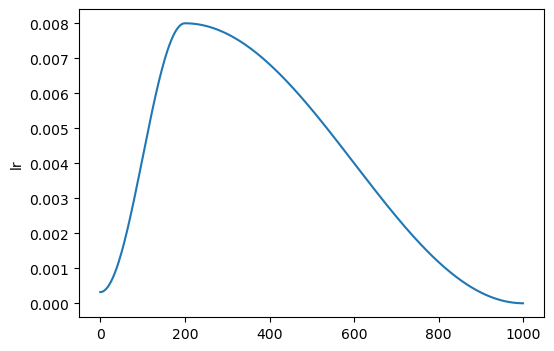

In [ ]:
#|echo: false
learn.recorder.plot_sched()

And without learning ratewarmup:

In [ ]:
#|hide
learn = synth_learner(100, 10)
learn.fit_cos_anneal(10, 8e-3, warm_pct=0)

epoch,train_loss,valid_loss,time
0,0.066619,0.011505,00:00
1,0.016760,0.011333,00:00
2,0.010673,0.011663,00:00
3,0.009802,0.011358,00:00
4,0.009989,0.011434,00:00
5,0.009777,0.011374,00:00
6,0.009323,0.011396,00:00
7,0.009720,0.011402,00:00
8,0.009358,0.011382,00:00
9,0.009729,0.011377,00:00


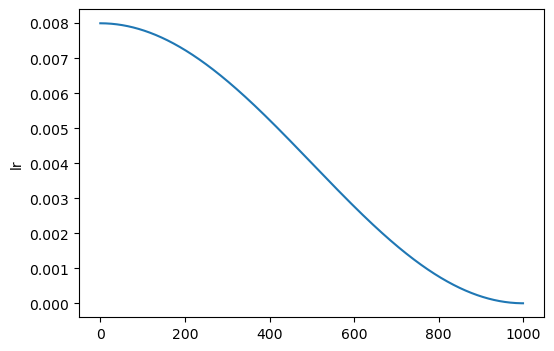

In [ ]:
#|echo: false
learn.recorder.plot_sched()

## Fit Flat Varied -

In [ ]:
#|export
@patch
def fit_flat_varied(self:Learner, 
    n_epoch:int, # Number of epochs
    start_lr:float|None=None, # Initial learning rate
    div_final:Number=1e5, # Final learning rate: `lr/div_final`
    pct_start:float=0.75, # Start learning rate cosine annealing
    wd:float|None=None, # Weight decay, defaults to `Optimizer` weight decay
    next_lr:listified[float]|slice|None=None, # Learning rates to switch to at `change_by`. Must be same length as `change_by`
    change_by:listified[int]|listified[float]|None=None, # Epochs or percent of steps to switch to `next_lr` by. Must be same length as `next_lr`
    change_time:listified[int]|listified[float]=1, # If greater than 0 (percent of steps or epochs), how long to change to `next_lr`. Must be same length as `next_lr`
    change_sched:listified[Callable[..., _Annealer]]|None=None, # Schedule(s) for change. Defaults to `SchedCos`. Must be same length as `next_lr`
    cbs:listified[Callback]|None=None, # Temporary Callbacks to apply during fit
    reset_opt:bool=False # Reset `Optimizer` before fit
):
    """
    Fit `self.model` for `n_epoch` at flat `start_lr`, then change to flat `next_lr` at `change_by`, 
    optionally with cosine annealing or custom `change_sched` over `change_time`. Final cosine annealing at `pct_start`.
    """
    assert isinstance(next_lr, (float, slice)) or (is_listish(next_lr) and len(next_lr)>=1), '`next_lr` must be float, slice, or list of float or slice'
    assert isinstance(change_by, (int, float, slice)) or (is_listish(change_by) and len(change_by)>=1), '`change_by` must be int, float, slice, or list of int, float, or slice'

    if self.opt is None: 
        self.create_opt()
    self.opt.set_hyper('lr', self.lr if start_lr is None else start_lr)
    start_lr = np.array([h['lr'] for h in self.opt.hypers])
    params_len = len(start_lr)

    if not is_listish(next_lr): 
        next_lr = [next_lr]
    if not is_listish(change_by): 
        change_by = [change_by]
    change_by = [i/n_epoch if i>=1 else i for i in change_by]
    assert len(change_by)==len(next_lr), '`next_lr` & `change_by` need to be same length'

    if not is_listish(change_time): 
        change_time = [change_time]*len(change_by)
    else: assert len(change_by)==len(change_time), '`change_time` list needs to be same length as `next_lr` & `change_by`'
    change_time = [i/n_epoch if i>=1 else i for i in change_time]

    if change_sched is not None: 
        if not is_listish(change_sched): 
            change_sched = [change_sched]
        assert len(change_by)==len(change_sched), '`next_lr` & `change_sched` need to be same length'

    pcts, scheds, last_lr, last_pct = [], [SchedNo(start_lr, start_lr)], start_lr, 0
    for i, cb in enumerate(change_by):
        if cb < pct_start:
            nlr = next_lr[i]
            if isinstance(nlr, slice):
                if nlr.start: nlr = even_mults(nlr.start, nlr.stop, params_len)
                else: nlr = [nlr.stop/10]*(params_len-1) + [nlr.stop]
                nlr=np.array(nlr)

            change_pct = cb - change_time[i]
            assert change_pct >= last_pct, f'{change_pct} in pos {i} of `change_by` overlaps with previous schedule {last_pct}'

            pcts.append(change_pct - sum(pcts))
            scheds.append(SchedNo(nlr, nlr))

            if change_time[i] > 0:
                pcts.append(change_time[i])
                if is_listish(change_sched): scheds.insert(-1, change_sched[i](last_lr, nlr))
                else: scheds.insert(-1, SchedCos(last_lr, nlr))

            last_lr = nlr
            last_pct = change_pct
        else: 
            warn(f'change_by: {change_by[i]} is after pct_start={pct_start} and ignored.')

    pcts += [pct_start - sum(pcts), 1-pct_start]
    scheds += [SchedCos(last_lr, last_lr/div_final)]
    scheds = {'lr': combine_scheds(pcts, scheds)}

    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)

`change_sched` can be one of [`SchedLin`](https://docs.fast.ai/callback.schedule.html#schedlin), [`SchedCos`](https://docs.fast.ai/callback.schedule.html#schedcos) (the default), [`SchedExp`](https://docs.fast.ai/callback.schedule.html#schedexp), [`SchedPoly`](https://docs.fast.ai/callback.schedule.html#schedpoly), or a custom [fastai annealer](https://docs.fast.ai/callback.schedule.html#annealer) based schedule. `SchedPoly` must be passed as partial function: `partial(SchedPoly, power=0.5)`.

### Example Fit Flat Varied Schedules

Discriminative Linear Warmup:

```python
learn.fit_flat_varied(4, slice(3e-5, 3e-3), next_lr=3e-3, change_by=1, change_time=1, change_sched=SchedLin)
```

![discriminative linear warmup](images/fit_flat_varied_3.png)

Multiple Cosine Annealing:

```python
learn.fit_flat_varied((15, 8e-3, next_lr=[6e-3, 4e-3], change_by=[4, 8], change_time=2)
```

![multiple cosine annealing](images/fit_flat_varied_1.png)


Immediate Change:

```python
learn.fit_flat_varied((10, 8e-3, next_lr=[6e-3, 4e-3], change_by=[0.25, 0.5], change_time=0)
```

![immediate change](images/fit_flat_varied_2.png)

epoch,train_loss,valid_loss,time
0,0.552985,0.008279,00:00
1,0.074130,0.008202,00:00
2,0.018833,0.008267,00:00
3,0.011750,0.008165,00:00


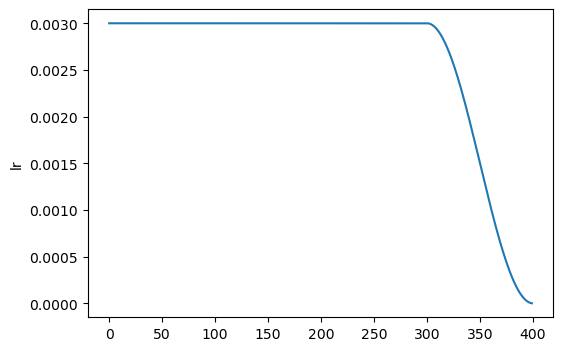

In [ ]:
#|hide
#|slow
learn = synth_learner(100, 10)
learn.fit_flat_varied(4, slice(3e-5, 3e-3), next_lr=3e-3, change_by=1, change_time=1, change_sched=SchedLin)
learn.recorder.plot_sched()

epoch,train_loss,valid_loss,time
0,0.239219,0.009471,00:00
1,0.037019,0.009402,00:00
2,0.013965,0.009658,00:00
3,0.010726,0.009394,00:00
4,0.010179,0.009376,00:00
5,0.010649,0.009525,00:00
6,0.010619,0.009379,00:00
7,0.010789,0.009462,00:00
8,0.010310,0.009485,00:00
9,0.010621,0.009402,00:00


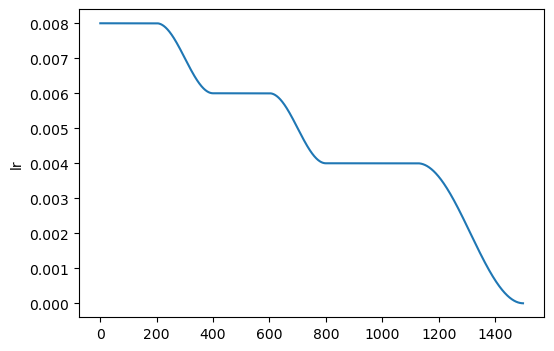

In [ ]:
#|hide
#|slow
learn = synth_learner(100, 10)
learn.fit_flat_varied(15, 8e-3, next_lr=[6e-3, 4e-3], change_by=[4, 8], change_time=2)
learn.recorder.plot_sched()

epoch,train_loss,valid_loss,time
0,0.403492,0.009634,00:00
1,0.056754,0.008926,00:00
2,0.016816,0.009177,00:00
3,0.011556,0.009228,00:00
4,0.010643,0.009077,00:00
5,0.010917,0.009311,00:00
6,0.010902,0.009123,00:00
7,0.010784,0.009274,00:00
8,0.010750,0.009101,00:00
9,0.010509,0.009157,00:00


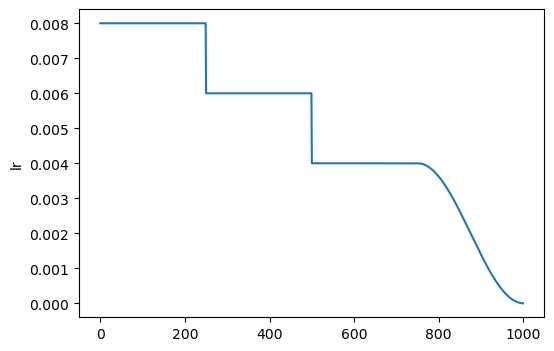

In [ ]:
#|hide
#|slow
learn = synth_learner(100, 10)
learn.fit_flat_varied(10, 8e-3, next_lr=[6e-3, 4e-3], change_by=[0.25, 0.5], change_time=0)
learn.recorder.plot_sched()